# note this code will be updated- it is not fully finished
# Time series analysis - Example code 28: Creating a simple model for the Helsinki energy data and predicting it using the format of the examination code.
**Lund University, Lund, Sweden**

See also the function examCode.m.

**Reference:** "An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson, Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, io
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main')))

from tsa_lth.analysis import plotACFnPACF, box_cox
from tsa_lth.tests import whiteness_test, check_if_normal
from tsa_lth.modelling import estimateARMA, polydiv

k = 1                                                # Prediction horizon.
groupNo = 1                                          # Example group number.
noLags = 200                                         # Number of lags to consider.
sweek = 168                                          # Weekly season.
sday = 24                                            # Daily season.

## Load the Helsinki energy data.

In [2]:
# Load dataHelsinki.mat
mat_data = io.loadmat('../data/dataHelsinki.mat')
powerload = mat_data['powerload'].flatten()

## Show entire data set, transform, and select training data.

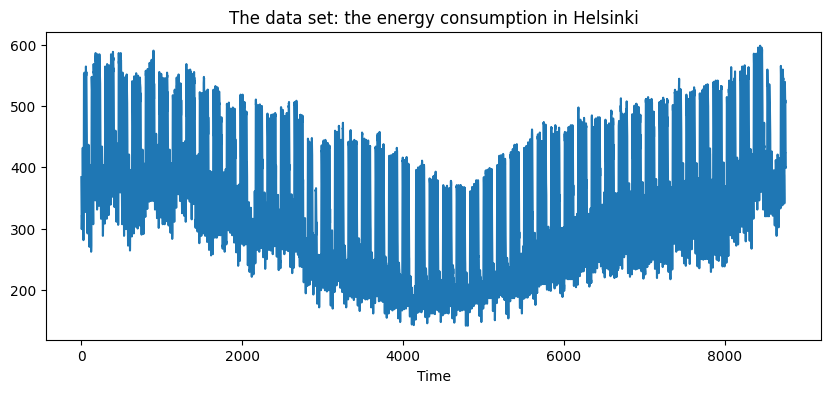

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(powerload)
plt.title('The data set: the energy consumption in Helsinki')
plt.xlabel('Time')
plt.show()

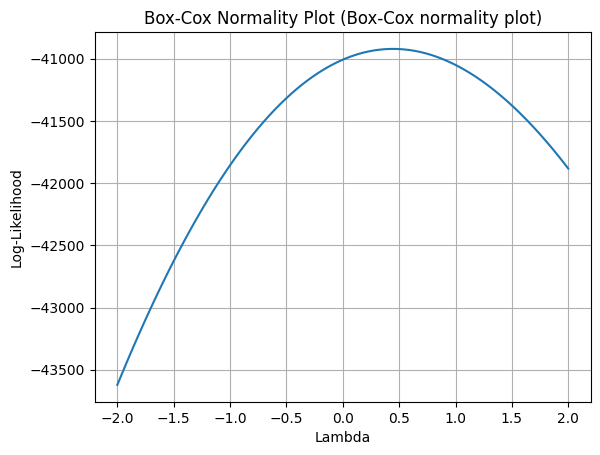

lambda_max = 0.4455
It seems reasonable to use a sqrt-transformation.


In [4]:
# Seems reasonable to use the sqrt as lambda = 0.4646
lambda_max, offsetValue = box_cox(powerload, plotIt=True, titleStr='Box-Cox normality plot', transform=False)
print(f'lambda_max = {lambda_max:.4f}')
print('It seems reasonable to use a sqrt-transformation.')

data = np.sqrt(powerload)

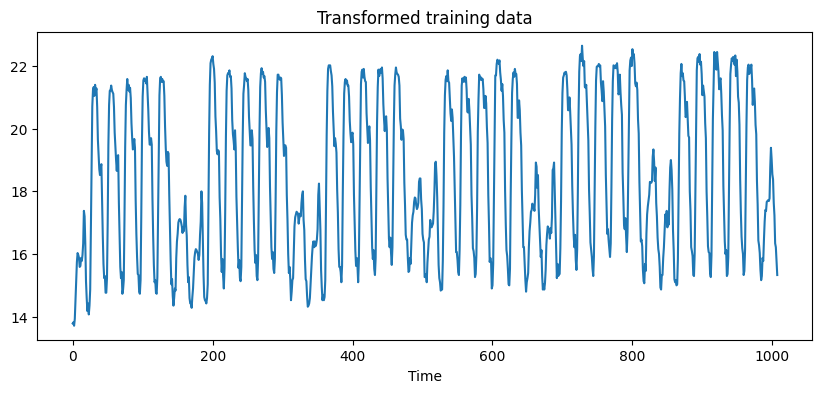

In [5]:
# Select some training data; these 6 weeks seems nice.
trainDataInd = np.arange(5980, 5980 + sweek*6)
trainingData = data[trainDataInd]                    # Notice that the model is built on only the training data.

plt.figure(figsize=(10, 4))
plt.plot(trainingData)
plt.title('Transformed training data')
plt.xlabel('Time')
plt.show()

## Model the data.
Remove seasons and form an ARMA model. Don't forget to remove samples.

In [6]:
AS = np.array([1, -1])
dayPoly = np.concatenate([[1], np.zeros(sday-1), [-1]])
weekPoly = np.concatenate([[1], np.zeros(sweek-1), [-1]])

y = signal.lfilter(dayPoly, 1, trainingData)
y = y[sday:]
y = signal.lfilter(weekPoly, 1, y)
y = y[sweek:]

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.4923(±0.0337)·z⁻¹ - 0.2998(±0.0336)·z⁻²
C(z) = 1.0 - 0.6152(±0.0281)·z⁻²⁴ - 0.6879(±0.0318)·z⁻¹⁶⁸ + 0.4495(±0.0373)·z⁻¹⁹²

Polynomial orders: nA = 2    nC = 192
Number of free coefficients: 5
Fit to estimation data (NRMSE): 47.97%
FPE : 0.047  MSE : 0.047
AIC : -170.427   BIC : -146.918



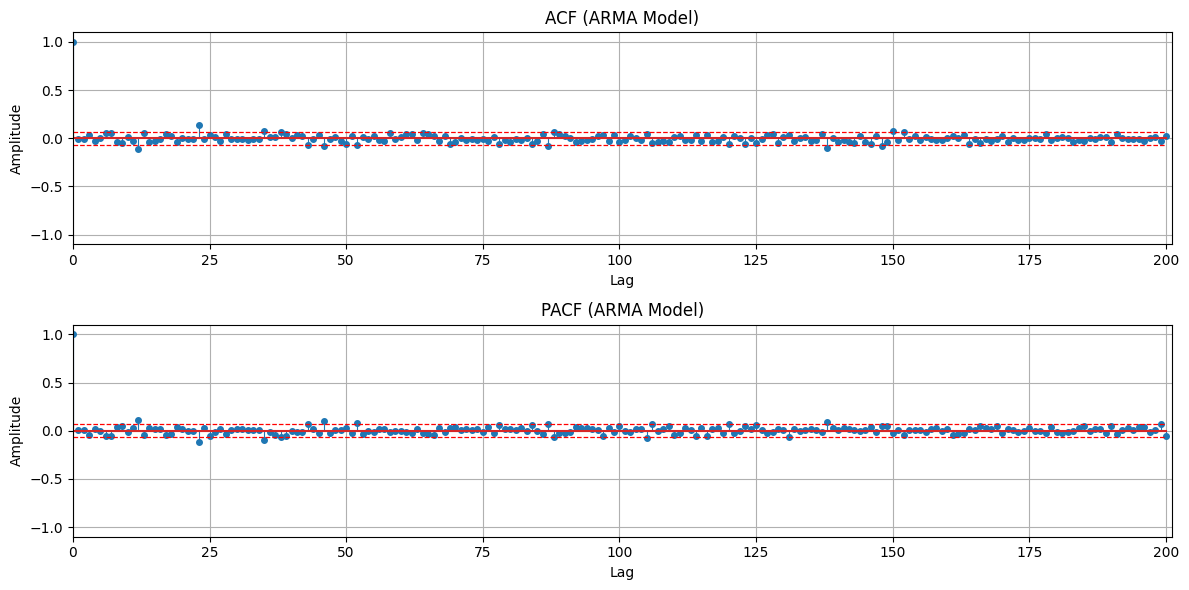

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 43.75 < 37.65)
  McLeod-Li test:        False (white if 135.73 < 37.65)
  Monti test:            False (white if 42.47 < 37.65)
  Sign change test:      True (white if 0.53 in [0.47,0.53])


In [7]:
# The model residual is not white, but reasonably close. We'll try this.
armaModel = estimateARMA(y, np.array([1, 1, 1]), np.convolve(weekPoly, dayPoly), 
                         titleStr='ARMA Model', noLags=200, plot=True)

## Form the k-step prediction using the examination format.
Here, the Am and Cm vectors stored in the prediction function have been computed as:

```
Am = conv(armaModel.A, dayPoly);
Am = conv(Am, weekPoly);
Cm = armaModel.C;
```

Notice that the prediction function does not take the parameters as input, so these need to be stored inside the function. Examine the call in the examCode.

**Note:** This section would normally call a prediction function like `predCodeA_grp001()`. For this example, we'll compute the prediction directly using the model parameters.

In [8]:
# Form the Am and Cm polynomials
Am = np.convolve(armaModel.A, dayPoly)
Am = np.convolve(Am, weekPoly)
Cm = armaModel.C

print(f'Length of Am polynomial: {len(Am)}')
print(f'Length of Cm polynomial: {len(Cm)}')

Length of Am polynomial: 195
Length of Cm polynomial: 193


In [9]:
# This is the test data. You will not be told which data is used to test the predictor.
testDataInd = np.arange(7155, 7155 + 4*sweek)

# Form the k-step prediction
# Notice that we work with data in the original domain; any needed transform has to be done inside the function.
F, G = polydiv(Cm, Am, k)

# Transform the data for prediction
data_sqrt = np.sqrt(powerload)
yhatk_sqrt = signal.lfilter(G, Cm, data_sqrt)

# Transform back to original domain
yhatk = yhatk_sqrt**2

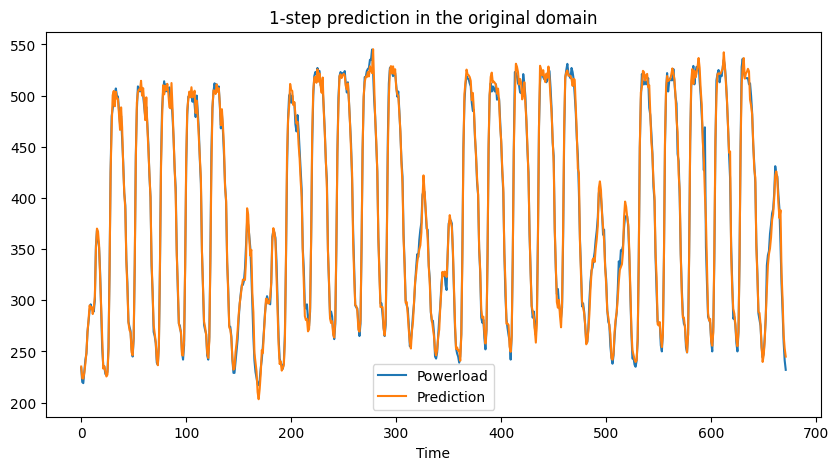

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(powerload[testDataInd], label='Powerload')
plt.plot(yhatk[testDataInd], label='Prediction')
plt.legend()
plt.title(f'{k}-step prediction in the original domain')
plt.xlabel('Time')
plt.show()

## Residual analysis

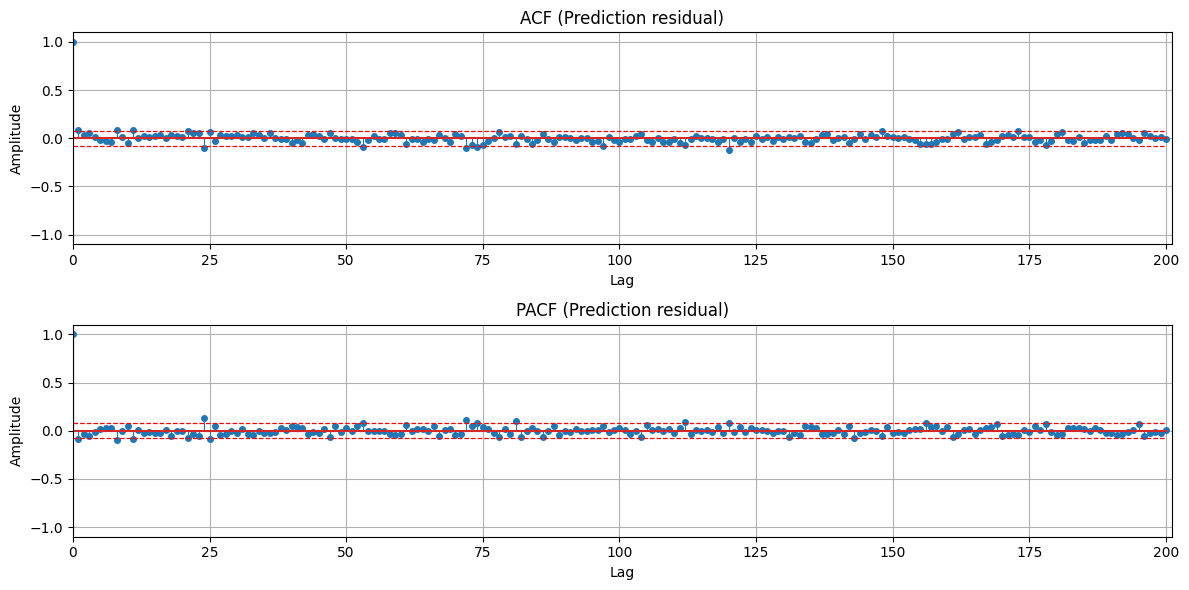

In [11]:
ehatA_P1 = powerload[testDataInd] - yhatk[testDataInd]
var_predA_1a = np.var(ehatA_P1)
acfEst, pacfEst = plotACFnPACF(ehatA_P1, noLags, titleStr='Prediction residual', return_val=True)

In [12]:
varY = np.var(powerload[testDataInd])
print('Prediction results for the one-step prediction:')
print(f'  The variance of the validations data is   {varY:7.2f}')
print(f'  The variance of the proposed predictor is {var_predA_1a:7.2f}. The normalized variance is {var_predA_1a/varY:5.4f}.')

whiteness_test(ehatA_P1)
check_if_normal(pacfEst[k:], 'PACF')

Prediction results for the one-step prediction:
  The variance of the validations data is   10446.54
  The variance of the proposed predictor is   59.40. The normalized variance is 0.0057.
Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 44.16 < 37.65)
  McLeod-Li test:        False (white if 39.65 < 37.65)
  Monti test:            False (white if 49.04 < 37.65)
  Sign change test:      False (white if 0.45 in [0.46,0.54])
The Jarque-Bera test indicates that the data is NORMAL distributed!
